# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [32]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
from pandas import *

Load feature names.

In [33]:
feature_names = []
with open('./Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [34]:
X, Y = [], []

with open('./Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000L, 126L) (1124L, 126L)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

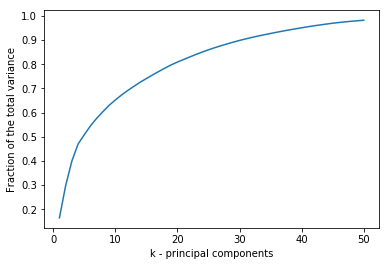

    total_variance_fraction
k                          
1                  0.164043
2                  0.297278
3                  0.399013
4                  0.469646
5                  0.508313
6                  0.545121
7                  0.576403
8                  0.603741
9                  0.629905
10                 0.652215
11                 0.672697
12                 0.691380
13                 0.708724
14                 0.725568
15                 0.740756
16                 0.755842
17                 0.770133
18                 0.784254
19                 0.797504
20                 0.808968
21                 0.819678
22                 0.830336
23                 0.840746
24                 0.850683
25                 0.859763
26                 0.868457
27                 0.876413
28                 0.884171
29                 0.891547
30                 0.898549
31                 0.904962
32                 0.911107
33                 0.916830
34                 0

In [35]:
def P1():
    ### STUDENT START ###
    
    # // instantiate a Principal Components Analysis (PCA) of 50 components
    pca = PCA(n_components=50)
    # // fit the PCA class
    pca.fit(train_data)
    # // used PCA explained_variance_ratio_ class to gather explained variance of each component
    pca_explained_variance = pca.explained_variance_ratio_
    # // calculate cumsum at each k level to calculate total variance explained
    cumsum_list = np.cumsum(pca_explained_variance[0:50])
    # // list of 1 to 50 by 1 to plot on x-axis
    k_list = list(range(1, 51))
    
    # // use matlibplot to plot xy data
    plt.plot(k_list, cumsum_list)
    plt.ylabel('Fraction of the total variance') 
    plt.xlabel('k - principal components')
    plt.show()
    
    # // use pandas to calculate cumsum to show the actual value per k - component    
    df = DataFrame({'k' : k_list, 'total_variance_fraction' : cumsum_list})
    df.set_index('k', inplace=True) 
    print df
    ### STUDENT END ###

# // run def: P1()
# // Input : NA
# // Output: XY plot of fraction of the total variance vs k - principal components 
# // followed by a table of data the plot visually shows
P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

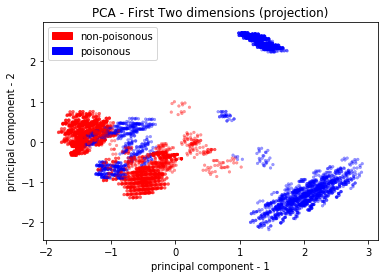

In [36]:
import matplotlib as mpl
import matplotlib.patches as mpatches

def P2():
    ### STUDENT START ###
    
    # // instantiate a Principal Components Analysis (PCA) of 2 components
    pca = PCA(n_components=2)
    # // fit data and transform to plot data
    pca_fit_transform = pca.fit_transform(train_data)
    
    # use mpl module to create color object
    cmap = mpl.colors.ListedColormap(['red','blue'])
    # map label onto color object: red -> non-poisonous (negative) and blue -> poisonous (positive)
    red_patch = mpatches.Patch(color='red', label='non-poisonous')
    blue_patch = mpatches.Patch(color='blue', label='poisonous')
    
    # // plot PCA 1-component vs PCA 2-component and map on color and label object
    # // use matlibplot to plot xy data
    plt.scatter(pca_fit_transform[:, 0], pca_fit_transform[:, 1], c=train_labels, alpha=0.4, s=8, lw=0.3, cmap=cmap)
    plt.xlabel("principal component - 1")
    plt.ylabel("principal component - 2")
    plt.legend(handles=[red_patch, blue_patch])
    plt.title("PCA - First Two dimensions (projection)")
    ### STUDENT END ###
    
# // run def: P2()
# // Input : NA
# // Output: XY scatterplot of poisonous vs non-poisonous mushrooms mapped two the first two 
# // PCA dimensions
P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

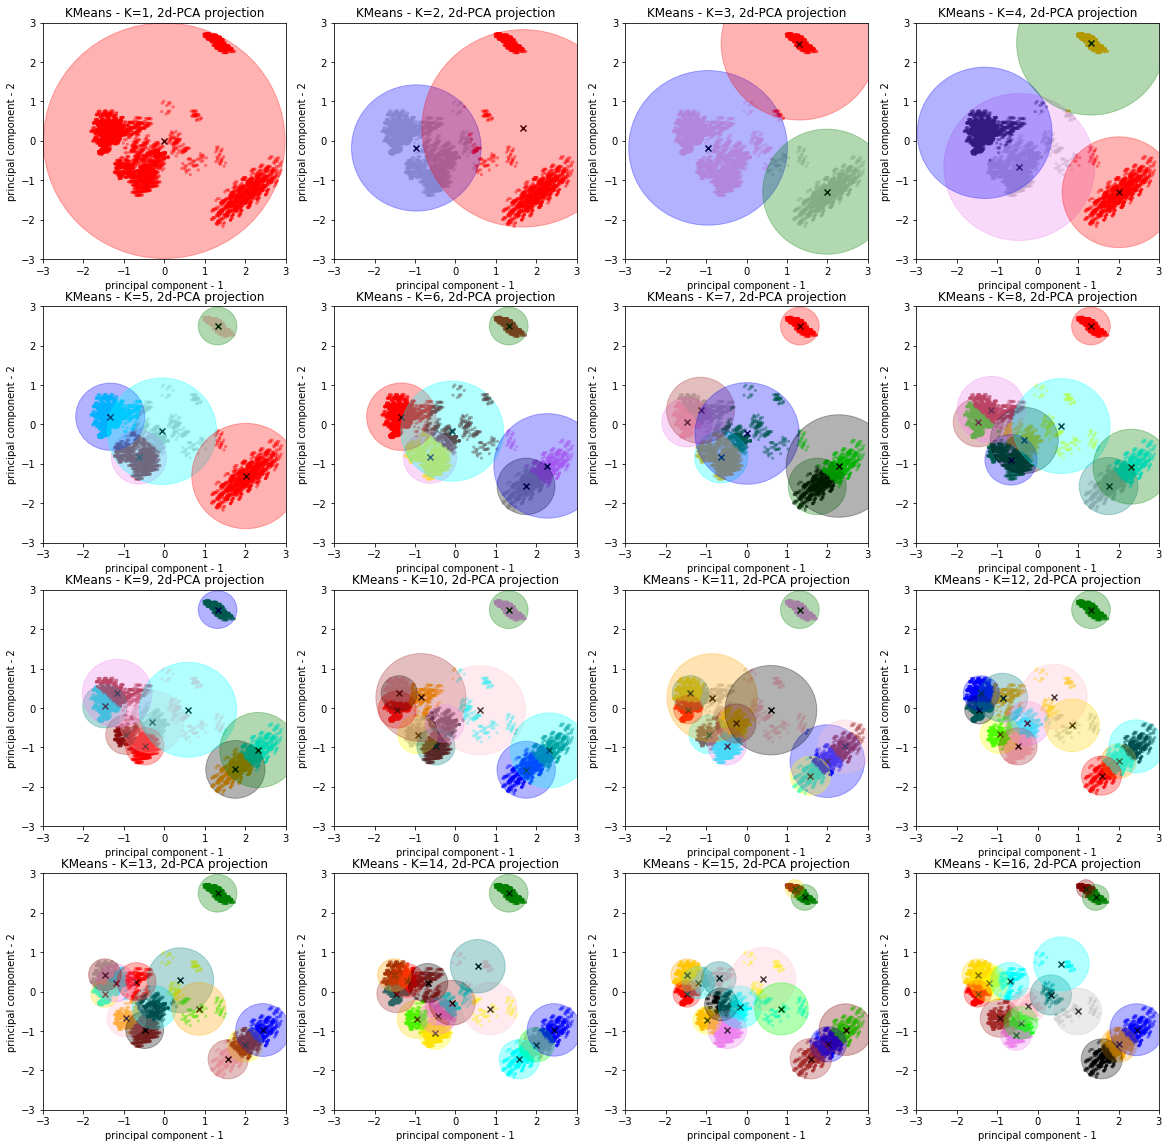

In [37]:
import matplotlib as mpl
from matplotlib import gridspec

def P3():
    ### STUDENT START ###
    
    # // use mpl module to create color object
    cmap_list = ['red', 'blue', 'green', 'violet', 'cyan', 'black', 'brown', 'teal', 
                                     'pink', 'yellow', 'orange', 'gold', 'maroon', 'lime', 'aqua', 'silver']
    cmap = mpl.colors.ListedColormap(cmap_list)

    # // instantiate a subplot and subplot shape
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(4, 4) 
    
    # // instantiate a Principal Components Analysis (PCA) of 2 components
    pca = PCA(n_components=2)
    # // fit data and transform to plot data
    pca_train = pca.fit_transform(train_data)
    # // loop through 16 KMean clusters to visualize data
    for i in range(1, 17):
        # // instantiate a KMeans class with looped interger value
        kmeans = KMeans(n_clusters=i, init='k-means++')
        # // fit the pca fitted data to the k_means class
        kmeans_fit = kmeans.fit(pca_train)
        # // calculate the mean centers for each cluster
        kmeans_center = kmeans_fit.cluster_centers_
        
        # // create a dataframe that grabs cluster_id,all the distances of the data to the center
        df = DataFrame({'cluster_id': kmeans_fit.labels_, 'distance': kmeans_fit.transform(pca_train).min(axis=1)})
        # // calculate the max distance to create the radius of the KMeans cluster
        cluster_info = df.groupby('cluster_id').max()
        
        # // use matlibplot to plot the data
        ax = plt.subplot(gs[i - 1])
        ax.scatter(pca_train[:, 0], pca_train[:, 1], c=df.cluster_id, cmap=cmap, alpha=0.4, s=8, lw=0.3)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_xlabel("principal component - 1")
        ax.set_ylabel("principal component - 2")
        ax.set_title('KMeans - K={}, 2d-PCA projection'.format(i), fontsize=12)
        
        # // loop through cluster id and plot matlibplot Circles over the scatter plot 2D projection mapped to colors of cluster
        for unique_id in df.cluster_id.unique():
            circle = plt.Circle((kmeans_center[unique_id][0], kmeans_center[unique_id][1]), 
                                cluster_info.loc[unique_id, 'distance'])
            circle.set_facecolor(cmap_list[unique_id])
            circle.set_edgecolor(cmap_list[unique_id])
            circle.set_alpha(0.3)
            ax.add_patch(circle)
            ax.scatter(kmeans_center[unique_id][0], kmeans_center[unique_id][1], marker = 'x', c='black', linewidths=5)
        ### STUDENT END ###

# // run def: P3()
# // Input : NA
# // Output: XY subplots of scatterplots of data with KMeans prediction of classes (visual overlayed)
# // PCA dimensions
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

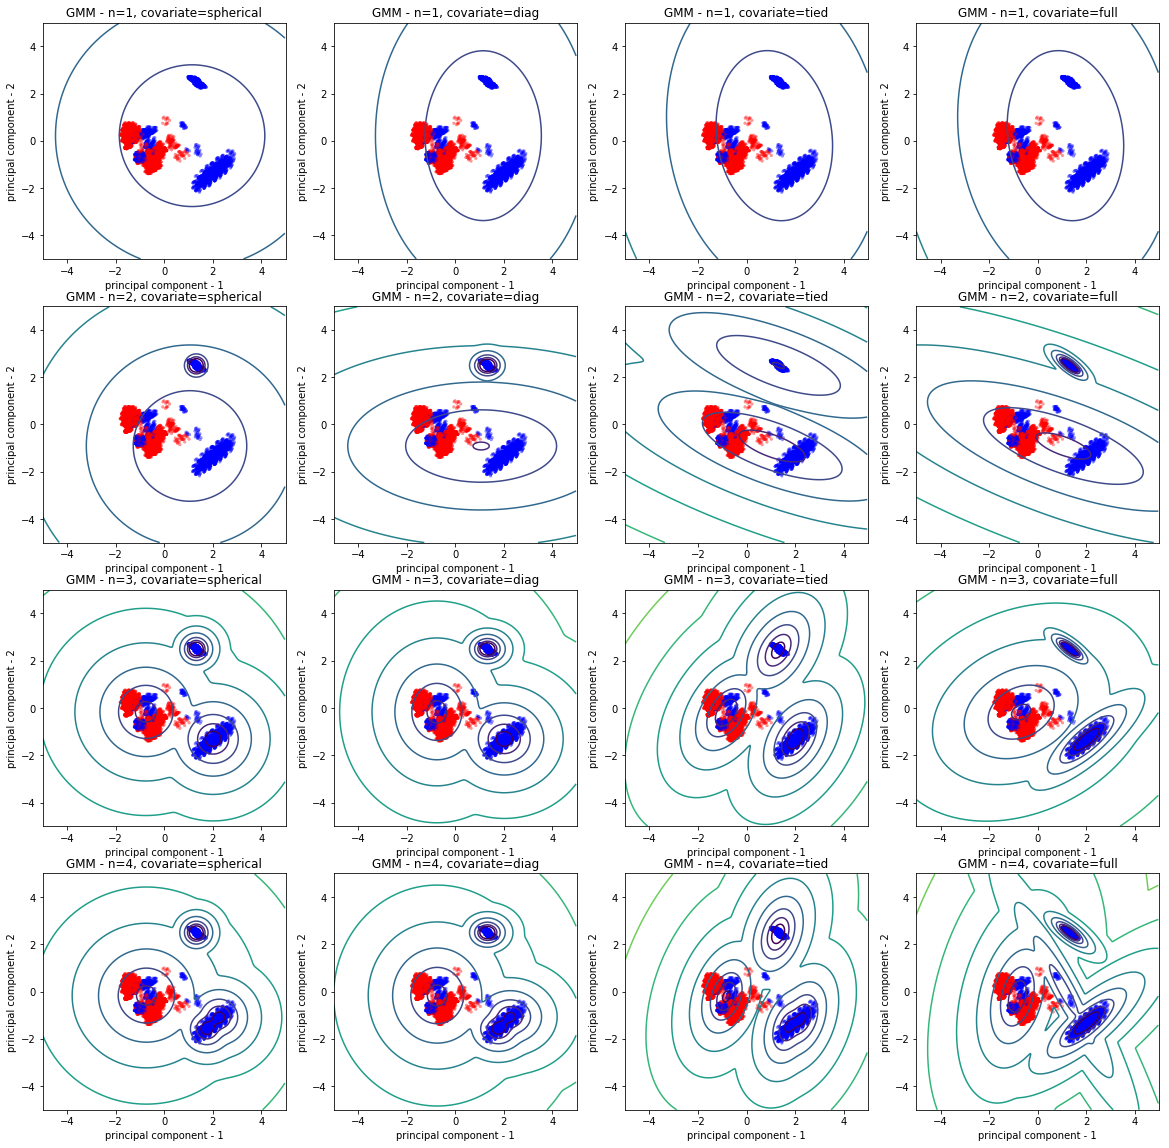

In [38]:
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def P4():
    ### STUDENT START ###
    # // use mpl module to create color object
    cmap = mpl.colors.ListedColormap(['red','blue'])
    covariance_matrix_type_list = ['spherical', 'diag', 'tied', 'full']
    
    # // code to set up contour lines (that represent gaussian grouping shapes)
    delta = 0.025
    x = np.arange(-5.0, 5.0, delta)
    y = np.arange(-5.0, 5.0, delta)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    
    # // instantiate a subplot and subplot shape
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(4, 4) 
    
    # // instantiate a Principal Components Analysis (PCA) of 2 components, fit/transform data and grab positive oucomes
    # // for later color mapping for visualization
    pca = PCA(n_components=2)
    pca_fit_transform = pca.fit_transform(train_data)
    positive_example_transformed = pca_fit_transform[train_labels==1,:]
    
    pic_itr = 0
    # // loop to vary the number of mixture components from 1-4 
    for i in range(1, 5):
        # // loop to vary the covariance matrix type ('spherical', 'diag', 'tied', 'full')
        for cov_type in covariance_matrix_type_list:
            # // fit GMM module with number of mixture components and covariance matrix type
            gmm = GMM(n_components = i, covariance_type=cov_type)
            # // fit the positive values data to show GMM contours
            gmm.fit(positive_example_transformed)
            
            # // matlibplot data with contours and mapped pos/neg values
            ax = plt.subplot(gs[pic_itr])
            ax.set_xlim(-5, 5)
            ax.set_ylim(-5, 5)
            ax.set_xlabel("principal component - 1")
            ax.set_ylabel("principal component - 2")
            ax.set_title('GMM - n={}, covariate={}'.format(i, cov_type), fontsize=12)
            ax.scatter(pca_fit_transform[:, 0], pca_fit_transform[:, 1], c=train_labels, alpha=0.4, s=8, lw=0.3, cmap=cmap)

            # // plot the contour with information from:
            # // http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
            Z = -gmm.score_samples(XX)[0].reshape(X.shape)
            ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0.01, 3, 10))
            
            pic_itr += 1    
    ### STUDENT END ###

# // run def: P4()
# // Input : NA
# // Output: XY subplots of scatterplots of data with KMeans prediction of classes (visual overlayed)
# // PCA dimensions
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [39]:
def P5():
    ### STUDENT START ###

    # // instantiate a Principal Components Analysis (PCA) of 2 components andfit/transform data
    pca = PCA(n_components=2)
    pca_fit_transform = pca.fit_transform(train_data)
    # // also transform test data to test prediction score of train
    pca_test = pca.transform(test_data)
    
    # // split data up from positive and negative poisonous characteristics
    positive_example_transformed = pca_fit_transform[train_labels==1,:]
    negative_example_transformed = pca_fit_transform[train_labels==0,:]
    
    # // fit GMM 4-component ful covariance model for positive poisonous characteristics
    gmm_pos = GMM(n_components = 4, covariance_type='full')
    gmm_pos.fit(positive_example_transformed)

    # // fit GMM 4-component ful covariance model for negative characteristics
    gmm_neg = GMM(n_components = 4, covariance_type='full')
    gmm_neg.fit(negative_example_transformed)
    
    # // calculate the prediction score of test data vs train fitted model
    score_pos = gmm_pos.score(pca_test)
    score_neg = gmm_neg.score(pca_test)

    # // calculate the prediction and then the accuracy and print the information
    predicted = (score_pos >= score_neg).astype(np.uint8)   
    accuracy = float((predicted == test_labels).sum()) / len(test_labels)
    print "The accuracy for the prompt in question 5 is: {}%".format(round(accuracy, 4) * 100)
    ### STUDENT END ###

# // run def: P5()
# // Input : NA
# // Output: Prediction accuracy of PCA transformed GMM models split up into pos/neg versions
P5()

The accuracy for the prompt in question 5 is: 95.11%


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [40]:
def P6():
    ### STUDENT START ###
    gmm_list = []
    pca_list = []
    cov_list = []
    param_list = []
    acc_list = []
    
    # // loop through a combination gmm,pca and covariance matrix types
    for gmm in xrange(1, 10):        
        for pca in xrange(1, 10):
            for cov_type in ['spherical', 'diag', 'tied', 'full']:
                # // diag type has cov matrix for each component of PCA
                if cov_type == 'diag':
                    temp_value = 4 * pca * gmm
                # // spherical type has cov matrix equal to 1
                elif cov_type == 'spherical':
                    temp_value = (pca + 1) * gmm * 2
                # // same as full covarianvce but for each GMM component
                elif cov_type == 'tied':
                    temp_value = ((pca + pca * (pca + 1)/(2 * gmm))) * gmm * 2
                # // full type has cov matrix equal to all the data (minus the duplicated values of a symmetric matrix)
                # // per pca component
                elif cov_type == 'full':
                    temp_value = ((pca + pca * (pca + 1)/(2))) * gmm * 2

                # // check if the paramater calculation is less than or equal to 50
                if temp_value <= 50:
                    # // same code below as P5(), see above for explanation
                    pca_use = PCA(n_components=pca)
                    pca_fit_transform = pca_use.fit_transform(train_data)

                    positive_example_transformed = pca_fit_transform[train_labels==1,:]
                    negative_example_transformed = pca_fit_transform[train_labels==0,:]
                    pca_test = pca_use.transform(test_data)

                    gmm_pos = GMM(n_components = gmm, covariance_type=cov_type)
                    gmm_pos.fit(positive_example_transformed)

                    gmm_neg = GMM(n_components = gmm, covariance_type=cov_type)
                    gmm_neg.fit(negative_example_transformed)

                    score_pos = gmm_pos.score(pca_test)
                    score_neg = gmm_neg.score(pca_test)                    
                    
                    prob_pos = gmm_pos.score(pca_test)
                    prob_neg = gmm_neg.score(pca_test)
                    preds = np.where(prob_pos >= prob_neg, 1, 0)
                    accuracy = metrics.accuracy_score(test_labels, preds)
                    
                    # // append information to list to create dataframe
                    gmm_list.append(gmm)
                    pca_list.append(pca)
                    cov_list.append(cov_type)
                    param_list.append(temp_value)
                    acc_list.append(accuracy)
                    
    # // create a dataframe of the values
    df_6 = pd.DataFrame({
        "gmm": gmm_list,
        "pca": pca_list,
        "cov": cov_list,
        "param_value": param_list,
        "acc": acc_list
    })

    # // sort value by accuracy (maximum) and see what model components make it up and print the results
    df_6 = df_6[["gmm", "pca", "cov", "param_value", "acc"]].sort_values('acc', ascending=False)
    print "The best model combination for GMM and PCA components under a totla of 50 are equal to:"
    print df_6.head(n=1)
                    
    return
    ### STUDENT END ###

# // run def: P6()
# // Input : NA
# // Output: Best GMM model with total parameter count under 50
P6()

The best model combination for GMM and PCA components under a totla of 50 are equal to:
    gmm  pca        cov  param_value      acc
67    3    7  spherical           48  0.97331
